In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from tqdm import tqdm

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

In [298]:
from collections import namedtuple, deque

Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward')
)

class replayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [555]:
agent.q_values

Q_network(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

In [577]:
# class Q_network(nn.Module):

#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.fc = nn.Linear(input_dim, input_dim)
#         self.fc2 = nn.Linear(input_dim, output_dim)

#     def forward(self, x):
#         x = torch.relu(self.fc2(x))
#         # x = torch.relu(self.fc2(x))
#         return x

class Q_network(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Q_network, self).__init__()
        self.layer1 = nn.Linear(n_observations, 4)
        self.layer2 = nn.Linear(4, 4)
        self.layer3 = nn.Linear(4, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

class CartPole_Agent:

    def __init__(
        self,
        learning_rate: float, 
        epsilon: float, 
        epsilon_decay: float, 
        final_epsilon: float, 
        discount_factor: float = 0.95,
        # memory_capacity: int = 10
        ):


        self.q_values = Q_network(4, env.action_space.n)
        self.q_values_target = Q_network(4, env.action_space.n)
        self.q_values_target.load_state_dict(self.q_values.state_dict())
        self.optimizer = optim.AdamW(self.q_values.parameters(), lr = learning_rate, amsgrad=True)
        
        # self.memory_capacity = memory_capacity
        # self.memory = replayMemory(self.memory_capacity)

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    # def record_obs(*args):
    #     self.memory.push(*args)

    
    def get_action(self, obs: tuple[float, float, float, float]) -> int:

        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            with torch.no_grad():
                action = int(torch.argmax(self.q_values(Tensor(obs))).detach().numpy())
            return action
    
    def update(
        self,
        obs: tuple[float, float, float, float],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[float, float, float, float]
        ):

        
        
        with torch.no_grad():
            expected_q_value = (not terminated) * torch.max(self.q_values_target(Tensor(next_obs))) * self.discount_factor + reward
        
        current_q_value = self.q_values(Tensor(obs))[action]

        # temporal_difference = (
        #     torch.pow((reward + self.discount_factor * future_q_value) - ,2)
        # )

        # temporal_difference.backward()
        criterion = nn.SmoothL1Loss()
        loss = criterion(current_q_value, expected_q_value)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.q_values.parameters(), 100)
        self.optimizer.step()

    def batch_update(self, batch):

        ## get states
        ## get actions
        ## get rewards

        
        
        with torch.no_grad():
            expected_q_value = (not terminated) * torch.max(self.q_values_target(Tensor(next_obs))) * self.discount_factor + reward
        
        current_q_value = self.q_values(Tensor(obs))[action]

        # temporal_difference = (
        #     torch.pow((reward + self.discount_factor * future_q_value) - ,2)
        # )

        # temporal_difference.backward()
        criterion = nn.SmoothL1Loss()
        loss = criterion(current_q_value, expected_q_value)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.q_values.parameters(), 100)
        self.optimizer.step()

        # self.training_error.append(temporal_difference.detach().numpy().item())

    def update_target_net(self):
        self.q_values_target.load_state_dict(self.q_values.state_dict())

    # def experience_replay(self):

    #     if len(self.memory) < BATCH_SIZE:
    #         return

    #     samples = self.memory.sample()
    #     batch = Transition(*zip(*transitions))

    #     non_final_mask = torch.tensor(
    #         tuple(map(lambda s: s is not None, batch.next_state)), 
    #         dtype = torch.bool
    #     )

    #     non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    #     state_batch = torch.cat(batch.state)
    #     action_batch = torch.cat(batch.action)
    #     reward_batch = torch.cat(batch.reward)

    #     state_action_values = self.q_values(state_batch).gather(1, action_batch)

    #     next_state_values = torch.zeros(BATCH_SIZE)

    #     with torch.no_grad():
    #         next_state_values[non_final_mask] = self.q_values(non_final_next_states).max(1)[0]

    #     expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

    #     criterion = nn.SmoothL1Loss()
    #     loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    #     optimizer.zero_grad()
    #     loss.backward()
    #     # torch.nn.untils
    #     optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)



In [522]:
## config
learning_rate = 0.001
discount_factor = 0.99
epsilon = 0.9
epsilon_decay = 0.001
final_epsilon = 1.0e-10

## define agent
agent = CartPole_Agent(
    learning_rate,
    epsilon,
    epsilon_decay,
    final_epsilon,
    discount_factor
)

In [580]:
from random import shuffle

def run_cart_pole(agent, n_episodes, train = True):
    env = gym.make("CartPole-v1")
    results = dict()
    batch = []
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset(seed=42)
        done = False
        results[episode] = dict()
        time_steps = 0

        while not done:
            
            action = agent.get_action(obs)

            results[episode][time_steps] = (obs, action)

            next_obs, reward, terminated, truncated, info = env.step(action)
            
            if train:
                # agent.update(obs, action, reward, terminated, next_obs)
                batch.append(Transition(*[obs, action, reward, terminated, next_obs]))
                
                target_net_state_dict = agent.q_values_target.state_dict()
                policy_net_state_dict = agent.q_values.state_dict()

                if len(batch) > 128:
                    shuffle(batch)
                    updates = batch[-128:]
                    agent.batch_update(updates)
                    # for event in batch[-128:]:
                    #     agent.update(*event)

                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
                agent.q_values_target.load_state_dict(target_net_state_dict)

            done = terminated or truncated
            obs = next_obs
            time_steps += 1

        agent.decay_epsilon()

    env.close()

    return results



In [574]:
import optuna


def objective(trial):

    ## config
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3, log = True)
    discount_factor = 0.99#trial.suggest_float('discount_factor', 0.5, 0.99)
    # K = trial.suggest_int('K', 1, 100)
    epsilon = trial.suggest_float('epsilon', 0.01, 0.9)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.001, 0.1, log = True)
    final_epsilon = trial.suggest_float('final_epsilon', 1.0e-5, 1.0e-2, log = True)

    ## define agent
    agent = CartPole_Agent(
        learning_rate,
        epsilon,
        epsilon_decay,
        final_epsilon,
        discount_factor
    )

    results = run_cart_pole(agent, 1000, train = True)
    score = np.mean([len(v.keys()) for k, v in results.items()][-25:])

    return score

In [575]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

print(study.best_params)

[I 2023-07-18 22:33:18,634] A new study created in memory with name: no-name-bc728be1-1a6e-43d5-acba-c4317a257192
100%|██████████| 1000/1000 [54:21<00:00,  3.26s/it] 
[I 2023-07-18 23:27:39,975] Trial 0 finished with value: 29.52 and parameters: {'learning_rate': 0.04182312075983238, 'epsilon': 0.758479281772695, 'epsilon_decay': 0.0010911631858452353, 'final_epsilon': 0.003561746789531447}. Best is trial 0 with value: 29.52.
100%|██████████| 1000/1000 [53:34<00:00,  3.21s/it] 
[I 2023-07-19 00:21:14,570] Trial 1 finished with value: 28.96 and parameters: {'learning_rate': 0.00599106314416218, 'epsilon': 0.3329131804677552, 'epsilon_decay': 0.020024387065283082, 'final_epsilon': 0.0014371823382603641}. Best is trial 0 with value: 29.52.
100%|██████████| 1000/1000 [56:12<00:00,  3.37s/it] 
[I 2023-07-19 01:17:27,096] Trial 2 finished with value: 31.52 and parameters: {'learning_rate': 0.051617277141307545, 'epsilon': 0.37718312970572804, 'epsilon_decay': 0.062013488305678474, 'final_eps

KeyboardInterrupt: 

In [512]:
optuna.visualization.plot_optimization_history(study)

In [529]:
optuna.visualization.plot_parallel_coordinate(study)

In [514]:
optuna.visualization.plot_slice(study)

In [515]:
optuna.visualization.plot_param_importances(study)

In [530]:
study.best_params

{'learning_rate': 0.2520536491705642,
 'K': 26,
 'epsilon': 0.25235390747288755,
 'epsilon_decay': 0.0946596212235749,
 'final_epsilon': 0.00011389566718410254}

100%|██████████| 500/500 [34:43<00:00,  4.17s/it] 


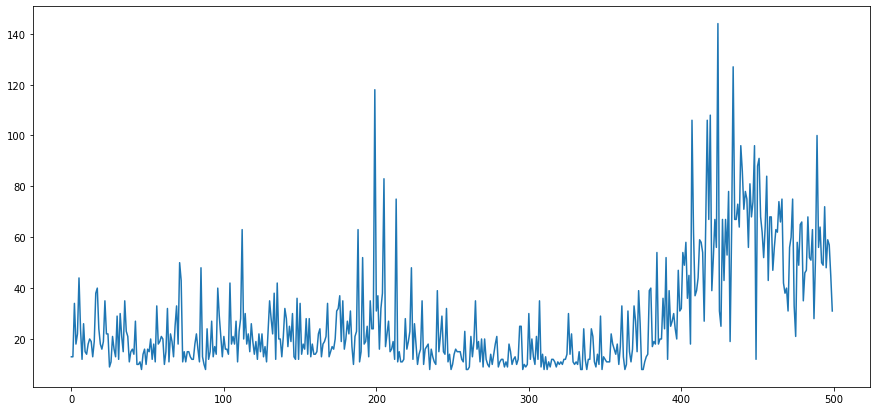

In [582]:
agent = CartPole_Agent(
    1.0e-4,
    0.9,
    0.001,
    0.05,
    0.99
)
results = run_cart_pole(agent, n_episodes=500, train = True)#study.best_params['K']

fig, ax = plt.subplots(figsize = (15, 7))
plt.plot([len(v.keys()) for k, v in results.items()]);

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [2:04:15<00:00, 14.91s/it]  


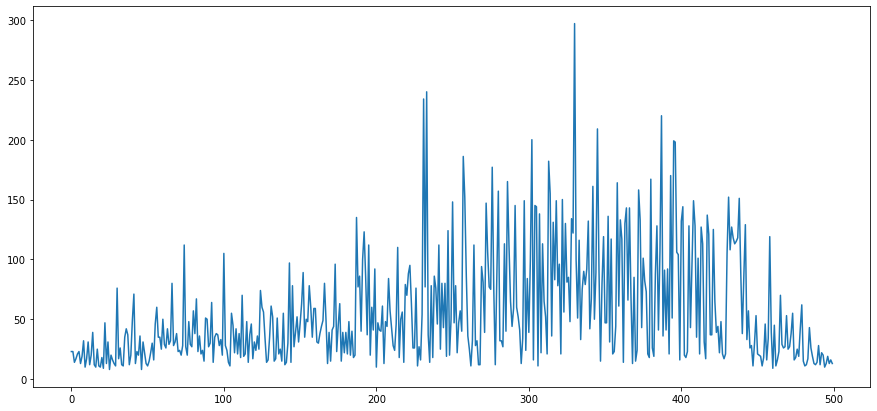

In [583]:
agent = CartPole_Agent(
    1.0e-4,
    0.9,
    0.001,
    0.05,
    0.99
)
results = run_cart_pole(agent, n_episodes=500, train = True)#study.best_params['K']

fig, ax = plt.subplots(figsize = (15, 7))
plt.plot([len(v.keys()) for k, v in results.items()]);

100%|██████████| 500/500 [42:01<00:00,  5.04s/it]


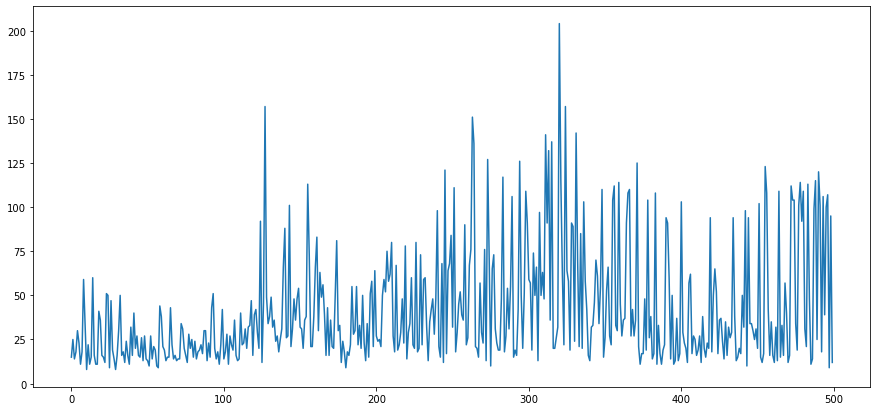

In [584]:
agent = CartPole_Agent(
    1.0e-4,
    0.9,
    0.001,
    0.05,
    0.99
)
results = run_cart_pole(agent, n_episodes=500, train = True)#study.best_params['K']

fig, ax = plt.subplots(figsize = (15, 7))
plt.plot([len(v.keys()) for k, v in results.items()]);

66.12


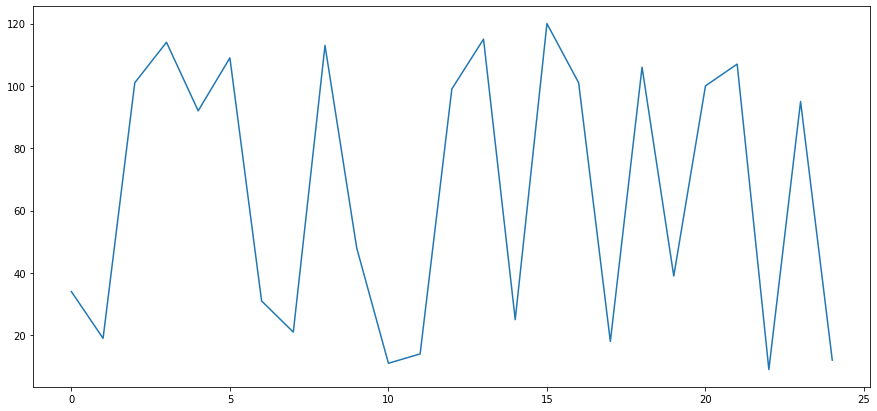

In [585]:
print(np.mean([len(v.keys()) for k, v in results.items()][-25:]))
fig, ax = plt.subplots(figsize = (15, 7))
plt.plot([len(v.keys()) for k, v in results.items()][-25:])

In [487]:
[len(v.keys()) for k, v in results.items()][-25:]

[8, 8, 8, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [274]:
env = gym.make("CartPole-v1")
n_episodes = 600
results = dict()

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset(seed=42)
    done = False
    results[episode] = dict()
    time_steps = 0

    while not done:
        
        results[episode][time_steps] = obs
        # print(episode, time_steps, obs)
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        obs = next_obs
        time_steps += 1

    agent.decay_epsilon()

env.close()


100%|██████████| 600/600 [00:07<00:00, 75.20it/s]


In [349]:
env = gym.make("CartPole-v1", render_mode="human")
n_episodes = 50
results = dict()

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset(seed=42)
    done = False
    results[episode] = dict()
    time_steps = 0

    while not done:
        
        results[episode][time_steps] = obs
        # print(episode, time_steps, obs)
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # agent.update(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        obs = next_obs
        time_steps += 1

    agent.decay_epsilon()

env.close()

100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


In [231]:
agent.q_values.fc.weight

Parameter containing:
tensor([[ 0.3416, -1.3312, -0.3715,  1.3079],
        [-0.1313,  1.3059, -0.2594, -1.5956]], requires_grad=True)

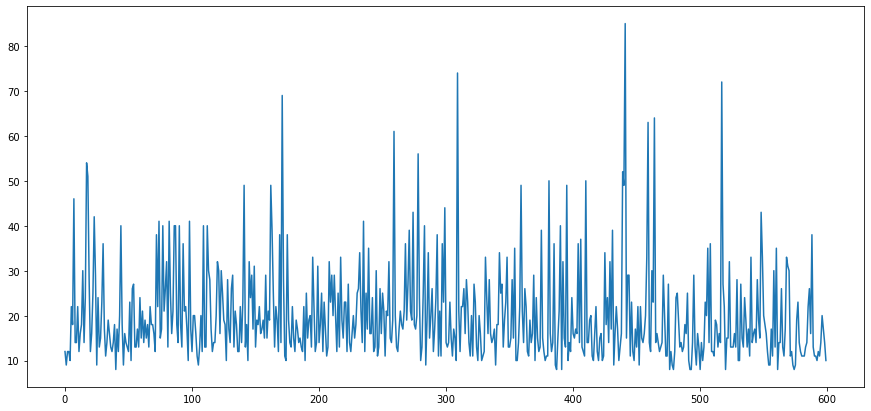

In [275]:
fig, ax = plt.subplots(figsize = (15, 7))
plt.plot([len(v.keys()) for k, v in results.items()])

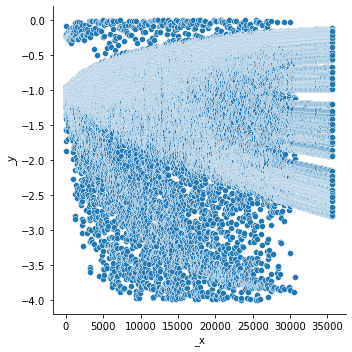

In [240]:



sns.relplot(data =agent.training_error)